In [1]:
import numpy as np
import edf
from time import time
import sys

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
traindata = './mnist_data/train.npz'
valdata = './mnist_data/test.npz'

data = np.load(traindata)
t_imgs = np.float32(data['imgs'])/255.
t_labels = np.float32(data['labels'])

data = np.load(valdata)
v_imgs = np.float32(data['imgs'])/255.
v_labels = np.float32(data['labels'])

7


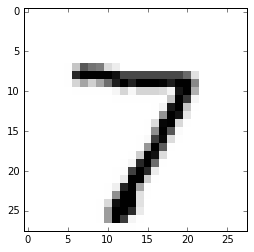

In [3]:
plt.imshow(data['imgs'][0].reshape(28,  28),  
           interpolation="none",  cmap="Greys")

print(data['labels'][0])

## Plain sigmoid activation function

sigmoid function $$\sigma(x) = \frac{1}{1 + e^{-x}}$$ looks like:

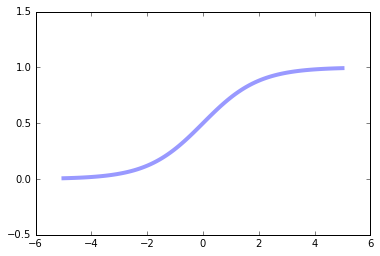

In [4]:
sigmoid = lambda x: 1/(1 + np.exp(-x))
xs = np.linspace(-5, 5, 100)
plt.plot(xs, sigmoid(xs), linewidth=4, alpha=0.4)
plt.ylim(-.5, 1.5);

How does the back-propagation look?

The partial derivative of sigmoid is  $$\partial_x \sigma =\frac{e^{-x}}{(1 + e^{-x})^2}$$. this can be reorganized in to $$\partial_x \sigma =\sigma(x)[1-\sigma(x)]$$ to use cached value from the forward pass.

The computation graph propagates `self.value` in the forward pass. On the backprop pass, the `backward` method updates the component's parameter (in this case `self.x`) by adding the gradient to the gradient of the parameter. Since the parameter is kept as a reference, after the full backward pass all contributions to the gradient of the parameter are added up.

each component has `self.value` and `self.grad`. 

```python
global components = [] 

class Sigmoid:

    def __init__(self, x):
        components.append(self)
        self.x = x
        self.grad = None if x.grad is None else DT(0)

    def forward(self):
        self.value = 1. / (1. + np.exp(-self.x.value))

    def backward(self):
        if self.x.grad is not None:
            self.x.grad = self.x.grad + self.grad * self.value * (1. - self.value)
```

In [5]:
########### we use sigmoid to demonstrate the edf works ###########
# to clear the globals in `edf`
edf.components = []
edf.params = []

# for repeatability
np.random.seed(0)
# Inputs and parameters
inp = edf.Value()
lab = edf.Value()

W1 = edf.Param(edf.xavier((28*28, 128)))
B1 = edf.Param(np.zeros((128)))
W2 = edf.Param(edf.xavier((128, 10)))
B2 = edf.Param(np.zeros((10)))

########### Network #############
A1 = edf.Add(edf.VDot(inp, W1), B1)
hidden = edf.Sigmoid(A1)
A2 = edf.Add(edf.VDot(hidden, W2), B2)
pred = edf.SoftMax(A2)
log = edf.Log(edf.Aref(pred, lab))
loss = edf.Mul(log, edf.Value(-1))
acc = edf.Accuracy(pred, lab)


# evaluation function
def eval(v_imgs,  v_labels):
    accuracy = 0.
    objective = 0.
    for k in range(len(v_labels)):    
        inp.set(v_imgs[k])
        lab.set(v_labels[k])
        edf.Forward()
        accuracy += acc.value
        objective += loss.value
        
    accuracy /= len(v_labels)
    objective /= len(v_labels)
    return accuracy,  objective

accuracy, objective = eval(v_imgs,  v_labels)
print("Random accuracy = %.4f" % accuracy)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
ep = 0
stime = time()
lr = 0.01 # learning rate
epoch = 5

while ep < epoch:

    # randon shuffle the train data in each epoch
    perm = np.random.permutation(len(t_labels))
    for k in range(len(t_labels)):    
        inp.set(t_imgs[perm[k]])
        lab.set(t_labels[perm[k]])
        edf.Forward()
        edf.Backward(loss)
        edf.SGD(lr)

    # evaluate on train set
    avg_acc,  avg_loss = eval(t_imgs,  t_labels)
    print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep,  avg_loss, time()-stime))
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # evaluate on testset
    avg_acc,  avg_loss = eval(v_imgs,  v_labels)
    print("test accuracy=%.4f" % avg_acc)
    test_loss.append(avg_loss)
    test_acc.append(avg_acc)
    stime = time()
    ep += 1

Random accuracy = 0.0958
Epoch 0: train loss = 0.2460 [26.028 secs]
test accuracy=0.9268
Epoch 1: train loss = 0.1687 [25.804 secs]
test accuracy=0.9507
Epoch 2: train loss = 0.1340 [26.474 secs]
test accuracy=0.9576
Epoch 3: train loss = 0.1057 [26.922 secs]
test accuracy=0.9636
Epoch 4: train loss = 0.0886 [26.314 secs]
test accuracy=0.9681


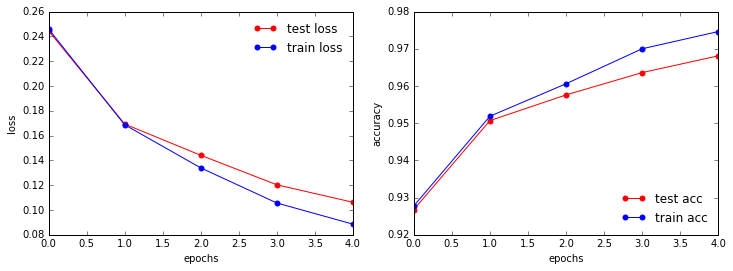

In [6]:
# plot
plt.figure(figsize=(12,  4))
plt.subplot(121)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(np.arange(len(test_loss)),  test_loss,  'ro-',  mec="none")
plt.plot(np.arange(len(train_loss)),  train_loss,  'bo-',  mec="none")
plt.legend(['test loss',  'train loss'],  loc='upper right',  frameon=False)

plt.subplot(122)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(np.arange(len(test_acc)),  test_acc,  'ro-',  mec="none")
plt.plot(np.arange(len(train_acc)),  train_acc,  'bo-',  mec="none")
plt.legend(['test acc',  'train acc'],  loc='lower right',  frameon=False)
plt.show()

## Using Tanh as the activation function

The Tanh activation function $$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$ looks like the following

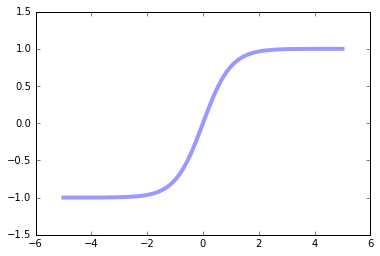

In [7]:
xs = np.linspace(-5, 5, 100)
plt.plot(xs, np.tanh(xs), linewidth=4, alpha=0.4)
plt.ylim(-1.5, 1.5);

In [8]:
# to clear the globals in `edf`
edf.components = []
edf.params = []

# please complete the forward and backward function in Tanh class and test it.
class Tanh:
    
    def __init__(self, x):
        edf.components.append(self)
        self.x = x
        self.grad = None if x.grad is None else edf.DT(0)

    def forward(self):
        self.value = np.tanh(self.x.value)
        
    def backward(self):
        if self.x.grad is None:
            return
        self.x.grad = self.x.grad + self.grad * (1 - np.tanh(self.x.value)**2)
        

# for repeatability
np.random.seed(0)
# Inputs and parameters
inp = edf.Value()
lab = edf.Value()

W1 = edf.Param(edf.xavier((28*28, 128)))
B1 = edf.Param(np.zeros((128)))
W2 = edf.Param(edf.xavier((128, 10)))
B2 = edf.Param(np.zeros((10)))

########### Model #############
# Here we change sigmoid to Tanh
A1 = edf.Add(edf.VDot(inp, W1), B1)
hidden = Tanh(A1)
A2 = edf.Add(edf.VDot(hidden, W2), B2)
pred = edf.SoftMax(A2)
log = edf.Log(edf.Aref(pred, lab))
loss = edf.Mul(log, edf.Value(-1))
acc = edf.Accuracy(pred, lab)


# evaluation function
def eval(v_imgs,  v_labels):
    accuracy = 0.
    objective = 0.
    for k in range(len(v_labels)):    
        inp.set(v_imgs[k])
        lab.set(v_labels[k])
        edf.Forward()
        accuracy += acc.value
        objective += loss.value
        
    accuracy /= len(v_labels)
    objective /= len(v_labels)
    return accuracy,  objective

accuracy, objective = eval(v_imgs, v_labels)
print("Random accuracy = %.4f" % accuracy)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
ep = 0
stime = time()
lr = 0.01
epoch = 5

while ep < epoch:

    # randon shuffle the train data in each epoch
    perm = np.random.permutation(len(t_labels))
    for k in range(len(t_labels)):    
        inp.set(t_imgs[perm[k]])
        lab.set(t_labels[perm[k]])
        edf.Forward()
        edf.Backward(loss)
        edf.SGD(lr)

    # evaluate on train set
    avg_acc,  avg_loss = eval(t_imgs, t_labels)
    print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, avg_loss, time()-stime))
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # evaluate on testset
    avg_acc,  avg_loss = eval(v_imgs, v_labels)
    print("test accuracy=%.4f" % avg_acc)
    test_loss.append(avg_loss)
    test_acc.append(avg_acc)
    stime = time()
    ep += 1

Random accuracy = 0.0875
Epoch 0: train loss = 0.1406 [26.773 secs]
test accuracy=0.9550
Epoch 1: train loss = 0.0833 [26.825 secs]
test accuracy=0.9697
Epoch 2: train loss = 0.0613 [26.768 secs]
test accuracy=0.9715
Epoch 3: train loss = 0.0414 [26.779 secs]
test accuracy=0.9742
Epoch 4: train loss = 0.0371 [26.779 secs]
test accuracy=0.9752


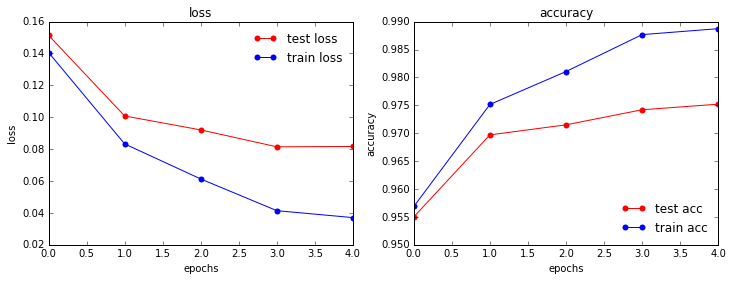

In [9]:
# after training,  you should be able to get around 97% test accuracy and training loss under 0.1 on mnist data.
# plot
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss")
plt.plot(np.arange(len(test_loss)), test_loss, 'ro-', mec="none")
plt.plot(np.arange(len(train_loss)), train_loss, 'bo-', mec="none")
plt.legend(['test loss',  'train loss'], loc='upper right', frameon=False)

plt.subplot(122)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy")
plt.plot(np.arange(len(test_acc)), test_acc, 'ro-', mec="none")
plt.plot(np.arange(len(train_acc)), train_acc, 'bo-', mec="none")
plt.legend(['test acc',  'train acc'],  loc='lower right', frameon=False)
plt.show()

## Using Rectified Linear Unit (ReLU) as the activation function

ReLU looks like the following:

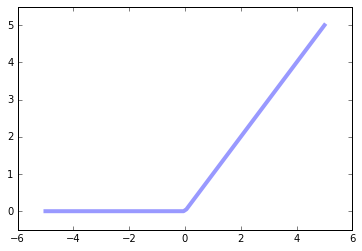

In [10]:
relu = lambda x: np.maximum(np.zeros(1).reshape(-1), x)

xs = np.linspace(-5, 5, 100)
plt.plot(xs, relu(xs), linewidth=4, alpha=0.4)
plt.ylim(-.5, 5.5);

In [11]:
# to clear the globals in `edf`
edf.components = []
edf.params = []

# please complete the forward and backward function in Relu class and test it.
class Relu:

    def __init__(self, x):
        edf.components.append(self)
        self.x = x
        self.grad = None if x.grad is None else edf.DT(0)

    def forward(self):
        self.value = np.maximum(self.x.value,  0)
        
    def backward(self):
        if self.x.grad is None:
            return
        self.x.grad = self.x.grad + self.grad *(1. * (self.x.value>0))
        
# for repeatability
np.random.seed(0)
# Inputs and parameters
inp = edf.Value()
lab = edf.Value()

W1 = edf.Param(edf.xavier((28*28, 128)))
B1 = edf.Param(np.zeros((128)))
W2 = edf.Param(edf.xavier((128, 10)))
B2 = edf.Param(np.zeros((10)))

########### Model #############
# Here we change sigmoid to relu
A1 = edf.Add(edf.VDot(inp, W1), B1)
hidden = Relu(A1)
A2 = edf.Add(edf.VDot(hidden, W2), B2)
pred = edf.SoftMax(A2)
log = edf.Log(edf.Aref(pred, lab))
loss = edf.Mul(log, edf.Value(-1))
acc = edf.Accuracy(pred, lab)

# evaluation function
def eval(v_imgs,  v_labels):
    accuracy = 0.
    objective = 0.
    for k in range(len(v_labels)):    
        inp.set(v_imgs[k])
        lab.set(v_labels[k])
        edf.Forward()
        accuracy += acc.value
        objective += loss.value
        
    accuracy /= len(v_labels)
    objective /= len(v_labels)
    return accuracy,  objective

accuracy, objective = eval(v_imgs, v_labels)
print("Random accuracy = %.4f" % accuracy)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
ep = 0
stime = time()
lr = 0.01
epoch = 5

while ep < epoch:

    # randon shuffle the train data in each epoch
    perm = np.random.permutation(len(t_labels))
    for k in range(len(t_labels)):    
        inp.set(t_imgs[perm[k]])
        lab.set(t_labels[perm[k]])
        edf.Forward()
        edf.Backward(loss)
        edf.SGD(lr)

    # evaluate on train set
    avg_acc,  avg_loss = eval(t_imgs, t_labels)
    print("Epoch %d: train loss = %.4f [%.3f secs]" % (ep, avg_loss, time()-stime))
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # evaluate on testset
    avg_acc,  avg_loss = eval(v_imgs, v_labels)
    print("test accuracy=%.4f" % avg_acc)
    test_loss.append(avg_loss)
    test_acc.append(avg_acc)
    stime = time()
    ep += 1

Random accuracy = 0.1323
Epoch 0: train loss = 0.1092 [25.768 secs]
test accuracy=0.9623
Epoch 1: train loss = 0.0686 [25.747 secs]
test accuracy=0.9714
Epoch 2: train loss = 0.0521 [25.736 secs]
test accuracy=0.9736
Epoch 3: train loss = 0.0391 [25.773 secs]
test accuracy=0.9759
Epoch 4: train loss = 0.0395 [25.743 secs]
test accuracy=0.9732


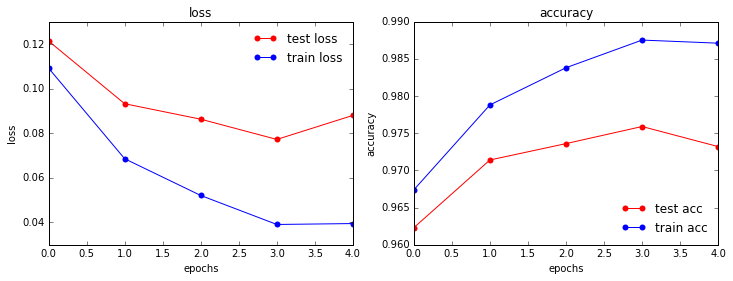

In [12]:
# after training,  you should be able to get around 97% test accuracy and training loss under 0.1 on mnist data.
# plot
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss")
plt.plot(np.arange(len(test_loss)), test_loss, 'ro-', mec="none")
plt.plot(np.arange(len(train_loss)), train_loss, 'bo-', mec="none")
plt.legend(['test loss',  'train loss'], loc='upper right', frameon=False)

plt.subplot(122)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy")
plt.plot(np.arange(len(test_acc)), test_acc, 'ro-', mec="none")
plt.plot(np.arange(len(train_acc)), train_acc, 'bo-', mec="none")
plt.legend(['test acc',  'train acc'],  loc='lower right', frameon=False)
plt.show()